In [9]:
#plot predicted ntibody escpe values with the structural distortion from the wildtype?...
import os
from Bio import SeqIO
import sys
sys.path.append('/mnt/ncshare/ozkilim/covid/covid_landscape/SARS2_RBD_Ab_escape_maps')
from bindingcalculator import BindingCalculator
from biopandas.pdb import PandasPdb
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
def distance_matrix_creator(PDB_filename):
    """"This function takes in a PDB and ... it returns a symetrix MxM matrix that is rotation and shift independant"""""
    ppdb = PandasPdb()
    data = ppdb.read_pdb(PDB_filename)
    atom_data = ppdb.df['ATOM']    
    mut_removed = atom_data
    position_matrix = mut_removed[["residue_number","x_coord" , "y_coord" , "z_coord"]]
    # aggresgate and take mean of xyz values for each residue as an approximation.
    aggregation_functions = {'x_coord': 'mean', 'y_coord': 'mean', 'z_coord': 'mean'}
    position_matrix = position_matrix.groupby(position_matrix['residue_number']).aggregate(aggregation_functions)  
    # cartersian productcartersian product of distance. 
    dist_mat = distance_matrix(position_matrix,position_matrix,p=2) #p=2 for euclidian disntace

    return dist_mat 


def get_blooms_vals(var,mut_name):
    variant_scores_path = "../SARS-CoV-2-RBD_DMS_Omicron/results/final_variant_scores/final_variant_scores.csv"

    variants_names = {
        "Wuhan-Hu-1_v2": "wuhan",
        "Alpha": "alpha", 
        "Beta": "beta",
        "Delta": "delta",
        "Eta": "eta",
        "Omicron_BA1":"omicron_ba1",
        "Omicron_BA2":"omicron_ba2"
    }

    scores_df = (
        pd.read_csv(variant_scores_path)
            .rename(columns = {"position":"site",
                            "delta_expr":"RBD expression", # rename for the selection menus 
                            "delta_bind":"ACE2 binding"    # rename for the selection menus 
                            })
            .replace({"target":variants_names})
    )
    varient_measurements = scores_df.loc[scores_df["target"] == var]    #here not selecting correctly?...
    expression = varient_measurements.loc[varient_measurements["mutation"]== mut_name]["RBD expression"].values
    binding = varient_measurements.loc[varient_measurements["mutation"]== mut_name]["ACE2 binding"].values  

    return binding, expression


bindcalc = BindingCalculator(csv_or_url='../../covid_landscape/SARS2_RBD_Ab_escape_maps/processed_data/escape_calculator_data.csv')
wuhan_mat = distance_matrix_creator("../structures/wuhan/rot-Wuhan_RBD_331_531_A344F.pdb")
# loop over fasta sequenes. 
wuhan_string = list("NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST")

all_vars = ["wuhan","alpha","beta","delta","eta","omicron_ba1","omicron_ba2"]
pdb_vars = ["Wuhan","Alpha","Beta","Delta","Eta","Omicron","OmicronBA2"]

all_rets = []
all_dists = []
all_ace2 = []
all_expr =[]
for var, pdb_var in zip(all_vars,pdb_vars):
    directory = "../FASTA/"+var
    dist_list = []
    ret_list = []
    ace2_list = []
    expr_list = []
    i=0
    for file in  os.listdir(directory):
        i = i+1
        try:
            path  = directory + "/" + file
            mut_name = file[-11:-6]
            fasta_sequences = SeqIO.read(path,'fasta')
            aa_seq = list(str(fasta_sequences.seq))
            positions = [i for i in range(len(aa_seq)) if aa_seq[i] != wuhan_string[i]]
            change_positions = [x+331 for x in positions] 
            # double check what value really need to be added to be correct..
            binding_ret = bindcalc.binding_retained(change_positions)
            pdb_file = "../structures/"+ var +"/rot-"+pdb_var+"_RBD_331_531_"+mut_name+".pdb"
            mat = distance_matrix_creator(pdb_file)
            dist = np.mean(np.square(wuhan_mat-mat))
            #also get both ace2 and expression data here 
            ace2, rbs_expr = get_blooms_vals(var,mut_name)
            # only if both calcualtions worked then append
            ret_list.append(binding_ret)
            dist_list.append(dist)
            ace2_list.append(ace2[0])
            expr_list.append(rbs_expr[0])
        except:
            pass
        # break
    print(var)
    all_rets.append(ret_list)
    all_dists.append(dist_list)
    all_ace2.append(ace2_list)
    all_expr.append(expr_list)

In [ ]:
np.save("antibody_escape_reasults_squared2.npy",np.array([all_rets,all_dists,all_ace2,all_expr]))

<ipython-input-3-b95d85a33499>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save("antibody_escape_reasults_squared.npy",np.array([all_rets,all_dists,all_ace2,all_expr]))


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

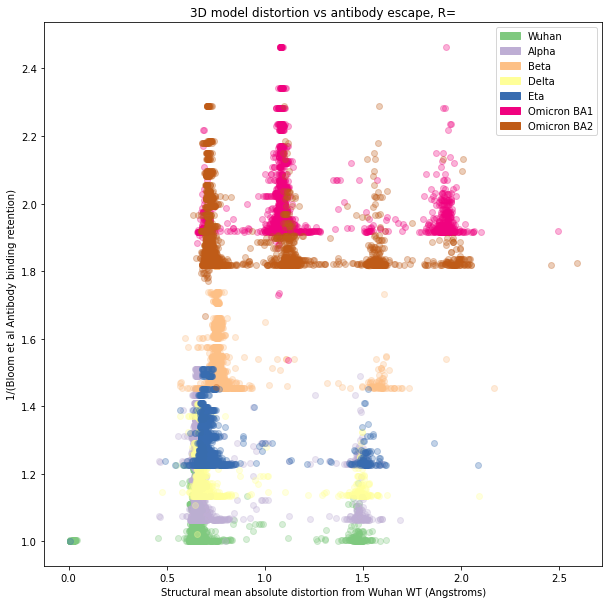

In [ ]:
# from the opened saved file.
data = np.load("antibody_escape_reasults_squared2.npy",allow_pickle=True)
all_rets,all_dists = data[0],data[1]


import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from scipy.stats.stats import pearsonr   
colors = cm.get_cmap('Accent')
fig = plt.figure(figsize=(10, 10))

for idx , (dist_list,ret_list) in enumerate(zip(all_dists,all_rets)):
    x = np.array(dist_list)
    y = np.array(ret_list)
    plt.scatter(x,1/y,alpha=0.3,c=colors(idx))


# make regression on all datapoints together.. to show as structure distorts mare there is more antibody escape..
# unpack all data into one long matrix and then regression on the combined numy array

X = np.concatenate(all_dists).ravel()
Y = 1/np.concatenate(all_rets).ravel()

# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(X.reshape(-1, 1), Y.reshape(-1, 1))  # perform linear regression
# y_pred = linear_regressor.predict(X.reshape(-1, 1))  # make predictions
# print(pearsonr(Y,y_pred)[0])
# plt.plot(X, y_pred, color='black', linewidth=0.5)


plt.title("3D model distortion vs antibody escape, R=")
plt.ylabel("1/(Bloom et al Antibody binding retention)")
plt.xlabel("Structural mean absolute distortion from Wuhan WT (Angstroms)")
# plt.xlim([0.3,0.75])
# plt.ylim([0.9,2.6])


Wuhan = mpatches.Patch(color=colors(0), label='Wuhan')
alpha = mpatches.Patch(color=colors(1), label='Alpha')
beta = mpatches.Patch(color=colors(2), label='Beta')
delta = mpatches.Patch(color=colors(3), label='Delta')
eta = mpatches.Patch(color=colors(4), label='Eta')
omi1 = mpatches.Patch(color=colors(5), label='Omicron BA1')
omi2 = mpatches.Patch(color=colors(6), label='Omicron BA2')

plt.legend(handles=[Wuhan,alpha,beta,delta,eta,omi1,omi2])

# all legend figure..
plt.show()
# fig.savefig("../reasults_figs/antibodyescape.png",facecolor='white', transparent=False,bbox_inches='tight')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

(3838,)
(3819,)
(7600,)
(7600,)
(3819,)
(3819,)
(3819,)
(3819,)
(3819,)
(3819,)
(3819,)
(3819,)
(3819,)
(3819,)


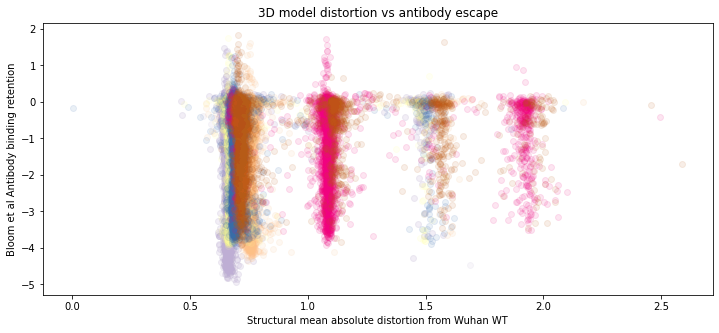

In [ ]:
colors = cm.get_cmap('Accent')
fig = plt.figure(figsize=(12, 5))
#some values are mssing... or nans?... 
for idx , (dist_list,ret_list) in enumerate(zip(all_dists,all_ace2)):
    try:
        x = np.array(dist_list)
        y = np.array(ret_list)
        print(x.shape)
        print(y.shape)
        plt.scatter(x,y,alpha=0.1,c=colors(idx))
    except:
        pass
plt.title("3D model distortion vs antibody escape")
plt.ylabel("Bloom et al Antibody binding retention")
plt.xlabel("Structural mean absolute distortion from Wuhan WT")
plt.show()

In [ ]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x.reshape(-1, 1), y.reshape(-1, 1))  # perform linear regression
y_pred = linear_regressor.predict(x.reshape(-1, 1))  # make predictions
plt.plot(x, y_pred, color='red', linewidth=1)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
Same plot for ACE2 and same expression..? automate simply. 